# Nitrogen timeseries graphs
Plots of daily maximum nitrogen over time, at one node location (node_id=6369)

In [1]:
import sys
import os
sys.path.insert(1, '../scripts/')
import xarray
import openpyxl
import yaml
import numpy as np
import pandas
import pathlib
import time
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
# used to make subplot labels consistent between figures
from matplotlib.offsetbox import AnchoredText
from ssm_utils import reshape_fvcom

In [2]:
with open('../etc/SSM_config.yaml', 'r') as file:
    ssm = yaml.safe_load(file)
# get shapefile path    
shp = ssm['paths']['shapefile']
# load shapefile into geopandas dataframe
gdf = gpd.read_file(shp)
DO_thresh = gdf['DO_std']
DO_thresh.shape

(7494,)

In [3]:
ssm['bar']={}
ssm['bar']['colors']={}
ssm['bar']['colors']['DOXG']='deepskyblue'
ssm['bar']['colors']['NO3']='y'
ssm['bar']['colors']['NH4']='darkolivegreen'

### Load surface and bottom values of NO3 and NH4, and bottom values of DOXG

In [4]:
node_id=6369 #Bbay low DO
# use NO3 directory to get a list of subdirectories 
model_var='NO3'
processed_netcdf_dir = pathlib.Path(ssm['paths']['processed_output'])/model_var
# get list of run sub-directories in processed netcdf directory
dir_list = os.listdir(processed_netcdf_dir)

In [5]:
dir_list

['wqm_reference',
 '1c_all_sog_riv_off',
 '2b_sog_river_2times',
 'wqm_baseline',
 '2a_sog_river_0.5times',
 '1d_small_sog_wwtp_off',
 '1e_med_sog_wwtp_off',
 '1b_all_sog_wwtp_off']

In [5]:
# create a dictionary structure for timeseries
np_operator='mean'
sfc={}
bot={}
for var in ['NO3','NH4','NH4+NO3']:
    sfc[var]={}
    bot[var]={}
    for run_dir in dir_list:
        sfc[var][run_dir]={}
        bot[var][run_dir]={}
np_operator='min'
var = 'DOXG'
sfc[var]={}
bot[var]={}
for run_dir in dir_list:
    sfc[var][run_dir]={}
    bot[var][run_dir]={}

In [7]:
# Re-order directory list for graphics purpose
dir_list=['wqm_baseline',
 'wqm_reference',
 '1c_all_sog_riv_off',
 '2a_sog_river_0.5times',
 '2b_sog_river_2times', 
 '1b_all_sog_wwtp_off',
 '1d_small_sog_wwtp_off',
 '1e_med_sog_wwtp_off']

In [8]:
%%time
for var in ['NO3','NH4','DOXG']:
    processed_netcdf_dir = pathlib.Path(ssm['paths']['processed_output'])/var
    for run_dir in dir_list:       
        if var != 'DOXG':
            # maximum for nitrogen
            np_operator='mean'
            # surface values 
            sfc_file=processed_netcdf_dir/run_dir/'surface'/f'daily_{np_operator}_{var}_surface.nc'
            with xarray.open_dataset(sfc_file) as ds:
                sfc[var][run_dir][f'{node_id}']=ds[f'{var}_daily_{np_operator}_surface'][:,node_id-1]
            # bottom values 
            bot_file=processed_netcdf_dir/run_dir/'bottom'/f'daily_{np_operator}_{var}_bottom.nc'
            with xarray.open_dataset(bot_file) as ds:
                bot[var][run_dir][f'{node_id}']=ds[f'{var}_daily_{np_operator}_bottom'][:,node_id-1]
        else:
            # minimum for dissolved O2
            np_operator='min'
            # bottom values 
            bot_file=processed_netcdf_dir/run_dir/'bottom'/f'daily_{np_operator}_{var}_bottom.nc'
            with xarray.open_dataset(bot_file) as ds:
                bot[var][run_dir][f'{node_id}']=ds[f'{var}_daily_{np_operator}_bottom'][:,node_id-1]

# create time series for NH4+NO3
for run_dir in dir_list:
    sfc['NH4+NO3'][run_dir][f'{node_id}']=sfc['NH4'][run_dir][f'{node_id}']+sfc['NO3'][run_dir][f'{node_id}']
    bot['NH4+NO3'][run_dir][f'{node_id}']=bot['NH4'][run_dir][f'{node_id}']+bot['NO3'][run_dir][f'{node_id}']

FileNotFoundError: [Errno 2] No such file or directory: b'/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/NO3/wqm_reference/surface/daily_max_NO3_surface.nc'

In [8]:
# create date vector
dti = pandas.date_range("2014-01-06", periods=361, freq="D")
dti[-1]

Timestamp('2015-01-01 00:00:00', freq='D')

wqm_baseline


findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


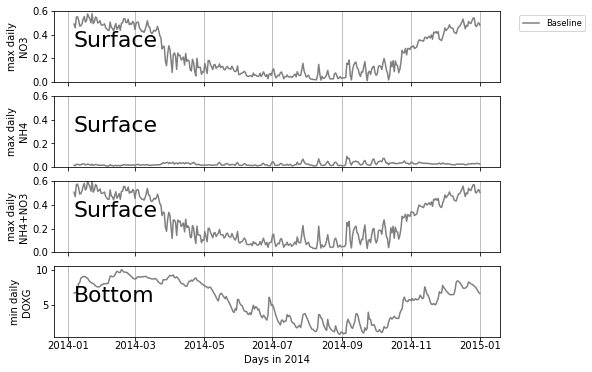

In [9]:
fig, axs = plt.subplots(4,1, figsize = (8,6))
run_dir=dir_list[0]
print(run_dir)
axs[0].plot(dti,sfc['NO3'][run_dir][f'{node_id}'],
    color=ssm['line']['color'][run_dir],
    label=ssm['run_information']['run_description'][run_dir]

)
axs[1].plot(dti,sfc['NH4'][run_dir][f'{node_id}'],
    color=ssm['line']['color'][run_dir]
)
axs[2].plot(dti,
    sfc['NH4+NO3'][run_dir][f'{node_id}'],
    color=ssm['line']['color'][run_dir]
)
axs[3].plot(dti,bot['DOXG'][run_dir][f'{node_id}'],
    color=ssm['line']['color'][run_dir]
)
leg=axs[0].legend(
bbox_to_anchor=(1.2,1),
loc='upper right'
)

opp=['max','max','max','min']
for idx,var in enumerate(['NO3','NH4','NH4+NO3','DOXG']):
    if var != 'DOXG':
        anchored_text = AnchoredText('Surface', loc=2,prop=dict(size=22),frameon=False)
    else:
        anchored_text = AnchoredText('Bottom', loc=2,prop=dict(size=22),frameon=False)
    axs[idx].add_artist(anchored_text)
    axs[idx].set_ylabel(f'{opp[idx]} daily\n{var}')
    axs[idx].grid(axis='x')
    if idx<3:
        axs[idx].set_xticklabels('')
        axs[idx].set_ylim(0,.6)
    else:
        axs[idx].set_xlabel('Days in 2014')
plt.savefig(pathlib.Path(ssm['paths']['graphics'])/'AnoxDaysDiff'/'BHAMbay_Baseline_TS.png',
            bbox_inches='tight',format='png')



Text(0.5, 1.0, 'Scenario - Baseline')

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


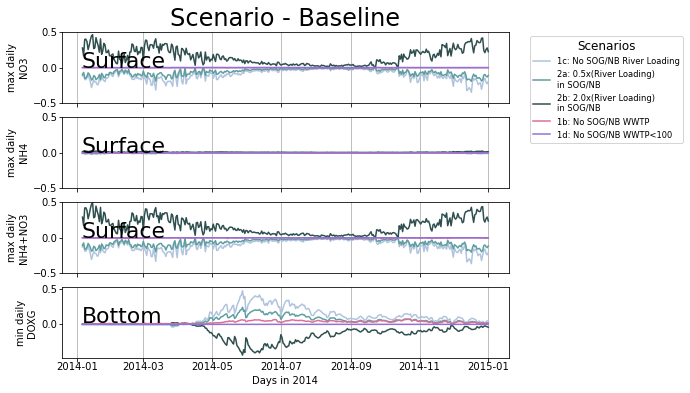

In [10]:
fig, axs = plt.subplots(4,1, figsize = (8,6))

for run_dir in dir_list[1:-1]:
    axs[0].plot(
        dti,
        sfc['NO3'][run_dir][f'{node_id}']-sfc['NO3']['wqm_baseline'][f'{node_id}'],
        color=ssm['line']['color'][run_dir],
        label=ssm['run_information']['run_description'][run_dir]
                
    )
    axs[1].plot(
        dti,
        sfc['NH4'][run_dir][f'{node_id}']-sfc['NH4']['wqm_baseline'][f'{node_id}'],
        color=ssm['line']['color'][run_dir]
    )
    axs[2].plot(
        dti,
        sfc['NH4+NO3'][run_dir][f'{node_id}']-sfc['NH4+NO3']['wqm_baseline'][f'{node_id}'],
        color=ssm['line']['color'][run_dir]
    )
    axs[3].plot(
        dti,
        bot['DOXG'][run_dir][f'{node_id}']-bot['DOXG']['wqm_baseline'][f'{node_id}'],
        color=ssm['line']['color'][run_dir]
    )
leg=axs[0].legend(
    bbox_to_anchor=(1.4,1),
    loc='upper right',
    title="Scenarios"
)

opp=['max','max','max','min']
for idx,var in enumerate(['NO3','NH4','NH4+NO3','DOXG']):
    if var != 'DOXG':
        anchored_text = AnchoredText('Surface', loc=2,prop=dict(size=22),frameon=False)
    else:
        anchored_text = AnchoredText('Bottom', loc=2,prop=dict(size=22),frameon=False)
    axs[idx].add_artist(anchored_text)
    axs[idx].set_ylabel(f'{opp[idx]} daily\n{var}')
    axs[idx].grid(axis='x')
    if idx<3:
        axs[idx].set_xticklabels('')
        axs[idx].set_ylim(-.5,.5)
    else:
        axs[idx].set_xlabel('Days in 2014')
axs[0].set_title('Scenario - Baseline',fontsize=24)
plt.savefig(pathlib.Path(ssm['paths']['graphics'])/'AnoxDaysDiff'/'BHAMbay_ScenarioDifference_TS.png',
            bbox_inches='tight',format='png')

Text(0.5, 1.0, 'Scenario - Baseline')

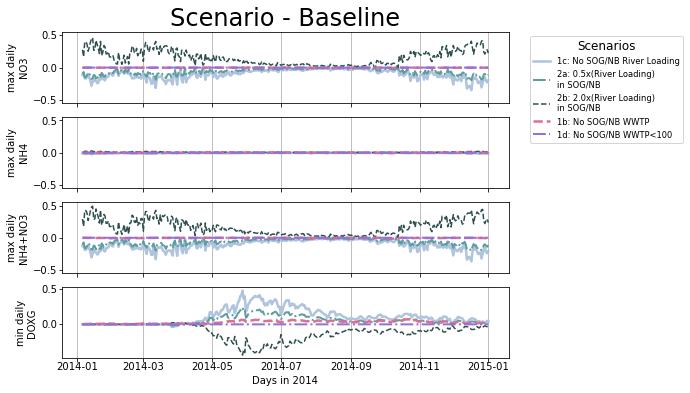

In [11]:
fig, axs = plt.subplots(4,1, figsize = (8,6))

for run_dir in dir_list[1:-1]:
    axs[0].plot(dti,
        sfc['NO3'][run_dir][f'{node_id}']-sfc['NO3']['wqm_baseline'][f'{node_id}'],
        color=ssm['line']['color'][run_dir],
        linestyle=ssm['line']['style'][run_dir],
        linewidth=ssm['line']['width'][run_dir],
        label=ssm['run_information']['run_description'][run_dir]
                
    )
    axs[1].plot(dti,
        sfc['NH4'][run_dir][f'{node_id}']-sfc['NH4']['wqm_baseline'][f'{node_id}'],
        color=ssm['line']['color'][run_dir],
        linestyle=ssm['line']['style'][run_dir],
        linewidth=ssm['line']['width'][run_dir]
    )
    axs[2].plot(dti,
        sfc['NH4+NO3'][run_dir][f'{node_id}']-sfc['NH4+NO3']['wqm_baseline'][f'{node_id}'],
        color=ssm['line']['color'][run_dir],
        linestyle=ssm['line']['style'][run_dir],
        linewidth=ssm['line']['width'][run_dir]
    )
    axs[3].plot(dti,
        bot['DOXG'][run_dir][f'{node_id}']-bot['DOXG']['wqm_baseline'][f'{node_id}'],
        color=ssm['line']['color'][run_dir],
        linestyle=ssm['line']['style'][run_dir],
        linewidth=ssm['line']['width'][run_dir],
    )
leg=axs[0].legend(
    bbox_to_anchor=(1.4,1),
    loc='upper right',
    title='Scenarios'
)

opp=['max','max','max','min']
for idx,var in enumerate(['NO3','NH4','NH4+NO3','DOXG']):
    axs[idx].set_ylabel(f'{opp[idx]} daily\n{var}')
    axs[idx].grid(axis='x')
    if idx<3:
        axs[idx].set_xticklabels('')
        axs[idx].set_ylim(-.55,.55)
    else:
        axs[idx].set_xlabel('Days in 2014')

axs[0].set_title('Scenario - Baseline',fontsize=24)

In [12]:
[run for run in dir_list[:2]]

['wqm_baseline', '1c_all_sog_riv_off']

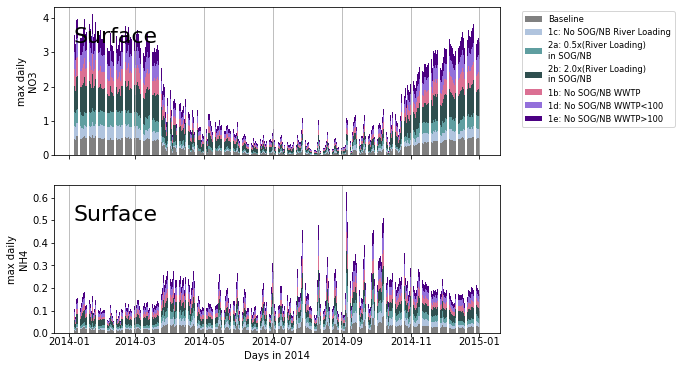

In [13]:
dir_list=['wqm_baseline',
 '1c_all_sog_riv_off',
 '2a_sog_river_0.5times',
 '2b_sog_river_2times', 
 '1b_all_sog_wwtp_off',
 '1d_small_sog_wwtp_off',
 '1e_med_sog_wwtp_off']

fig, axs = plt.subplots(2,1, figsize = (8,6))

for idx,run_dir in enumerate(dir_list):
    if idx>0:
        # add up no3 and nh4 in previous run directories to define 
        # bar graph "bottom"
        no3_sfc_list+=sfc['NO3'][dir_list[idx-1]][f'{node_id}'] 
        nh4_sfc_list+=sfc['NH4'][dir_list[idx-1]][f'{node_id}'] 
        axs[0].bar(dti,sfc['NO3'][run_dir][f'{node_id}'],
            color=ssm['line']['color'][run_dir],
            bottom=no3_sfc_list,
            label=ssm['run_information']['run_description'][run_dir]

        )
        axs[1].bar(dti,sfc['NH4'][run_dir][f'{node_id}'],
            color=ssm['line']['color'][run_dir],
            bottom=nh4_sfc_list
        )
    
    else:
        no3_sfc_list=np.zeros(sfc['NO3'][run_dir][f'{node_id}'].shape) 
        nh4_sfc_list=np.zeros(sfc['NH4'][run_dir][f'{node_id}'].shape)
        
        axs[0].bar(dti,sfc['NO3'][run_dir][f'{node_id}'],
        color=ssm['line']['color'][run_dir],
        label=ssm['run_information']['run_description'][run_dir]               
        )
        axs[1].bar(dti,sfc['NH4'][run_dir][f'{node_id}'],
            color=ssm['line']['color'][run_dir],
        )
    
leg=axs[0].legend(
    bbox_to_anchor=(1.4,1),
    loc='upper right'
)

opp=['max','max']
for idx,var in enumerate(['NO3','NH4']):
    axs[idx].set_ylabel(f'{opp[idx]} daily\n{var}')
    axs[idx].grid(axis='y')
    axs[idx].grid(axis='x')
    axs[idx].ylim(0,4)
    anchored_text = AnchoredText('Surface', loc=2,prop=dict(size=22),frameon=False)
    axs[idx].add_artist(anchored_text)
    if idx<1:
        axs[idx].set_xticklabels('')
    else:
        axs[idx].set_xlabel('Days in 2014')
plt.savefig(pathlib.Path(ssm['paths']['graphics'])/'AnoxDaysDiff'/'BHAMbay_Scenarios_bargraph_TS.png',
            bbox_inches='tight',format='png')

## Evaluate daily variability in NO3

In [14]:
%%time
path='/mmfs1/gscratch/ssmc/USRS/PSI/Sukyong/kingcounty/wqm_baseline/ssm_output.nc'
ds = xarray.open_dataset(path,engine='netcdf4')
hourly_values = reshape_fvcom(
    ds['NO3'],'days'
)

8784 10 16012
CPU times: user 1.5 s, sys: 4.87 s, total: 6.37 s
Wall time: 2min 40s


In [15]:
hourly_values.shape

(366, 24, 10, 16012)

In [16]:
sfc={}
bot={}
wc={}
for var in ['range','max','median','mean','median-max']:
    sfc[var]=[]
    bot[var]=[]
    wc[var]=[]
print(node_id)
for day in range(5,366):
    #surface
    sfc_max=np.max(hourly_values[day,:,0,node_id-1])
    sfc_min=np.min(hourly_values[day,:,0,node_id-1])
    sfc_median=np.median(hourly_values[day,:,0,node_id-1])
    sfc_mean=np.mean(hourly_values[day,:,0,node_id-1])
    sfc_range = sfc_max - sfc_min
    #bottom
    bot_max=np.max(hourly_values[day,:,9,node_id-1])
    bot_min=np.min(hourly_values[day,:,9,node_id-1])
    bot_median=np.median(hourly_values[day,:,9,node_id-1])
    bot_mean=np.mean(hourly_values[day,:,9,node_id-1])
    bot_range = bot_max - bot_min
    # water column
    wc_max=np.max(np.max(hourly_values[day,:,:,node_id-1]))
    wc_min=np.min(np.min(hourly_values[day,:,:,node_id-1]))
    wc_mean=np.mean(np.mean(hourly_values[day,:,:,node_id-1]))
    #wc_mean=np.median(np.median(hourly_values[day,:,:,node_id-1]))
    wc_range=wc_max-wc_min
    # plot values 
    bot['range'].append(bot_range)
    bot['max'].append(bot_max)
    bot['median'].append(bot_median)
    bot['mean'].append(bot_mean)
    bot['median-max'].append(bot_median-bot_max)
    sfc['range'].append(sfc_range)
    sfc['max'].append(sfc_max)
    sfc['median'].append(sfc_median)
    sfc['mean'].append(sfc_mean)
    sfc['median-max'].append(sfc_median-sfc_max)
    wc['range'].append(wc_range)
    wc['max'].append(wc_max)
    wc['mean'].append(wc_mean)
    

6369


## Plot bottom variability

The max difference between the bottom, median and the bottom, max daily value is -0.04
The maximum range of in bottom, daily NO3  values is: 0.08
For most of the days, the maximum, bottom daily value is around:  0.29


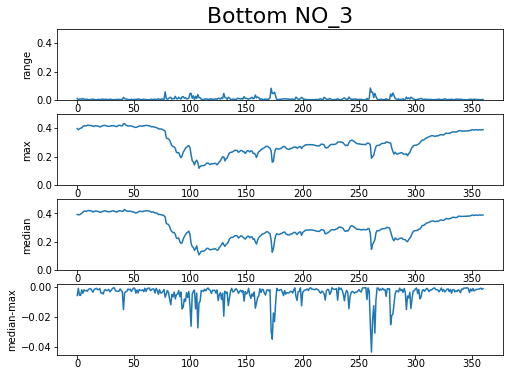

In [17]:
fig, axs = plt.subplots(4,1, figsize = (8,6))
axs[0].plot(bot['range'])
axs[1].plot(bot['max'])
axs[2].plot(bot['median'])
axs[3].plot(bot['median-max'])

axs[0].set_title('Bottom NO_3',fontsize=22)
axs[0].set_ylabel('range')
axs[1].set_ylabel('max')
axs[2].set_ylabel('median')
axs[3].set_ylabel('median-max')
for ii in range(0,3):
    axs[ii].set_ylim(0,.5)

print(f"The max difference between the bottom, median and the bottom, max daily value is {np.min(np.asarray(bot['median-max'])):.2f}")
print(f"The maximum range of in bottom, daily NO3  values is: {np.max(np.asarray(bot['range'])):.2f}")
print(f"For most of the days, the maximum, bottom daily value is around:  {np.median(np.asarray(bot['max'])):.2f}")

## Plot surface variability

The max difference between the surface median and the surface max daily value is -0.22
The maximum range of in surface, daily NO3 is: 0.24
For most of the days, the maximum, surface, daily value is around:  0.17


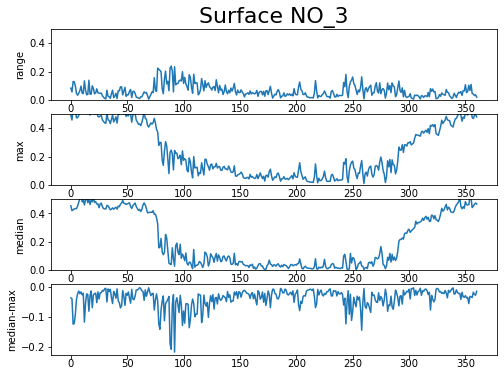

In [18]:
fig, axs = plt.subplots(4,1, figsize = (8,6))
axs[0].plot(sfc['range'])
axs[1].plot(sfc['max'])
axs[2].plot(sfc['median'])
axs[3].plot(sfc['median-max'])

axs[0].set_title('Surface NO_3',fontsize=22)
axs[0].set_ylabel('range')
axs[1].set_ylabel('max')
axs[2].set_ylabel('median')
axs[3].set_ylabel('median-max')
for ii in range(0,3):
    axs[ii].set_ylim(0,.5)

print(f"The max difference between the surface median and the surface max daily value is {np.min(np.asarray(sfc['median-max'])):.2f}")
print(f"The maximum range of in surface, daily NO3 is: {np.max(np.asarray(sfc['range'])):.2f}")
print(f"For most of the days, the maximum, surface, daily value is around:  {np.median(np.asarray(sfc['max'])):.2f}")

## Plot water column values

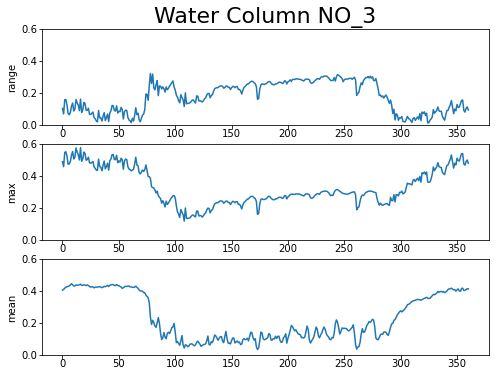

In [19]:
fig, axs = plt.subplots(1,1, figsize = (8,3))
axs.plot(wc['mean'], label="mean")
axs.fill_between(x, wc['min'], wc['max'], label="range")

axs.set_title('Water Column NO_3',fontsize=22)
axs.set_ylabel('Nitrogen ')

for ii in range(0,3):
    axs[ii].set_ylim(0,.6)

## Difference between surface/bottom max and water column max

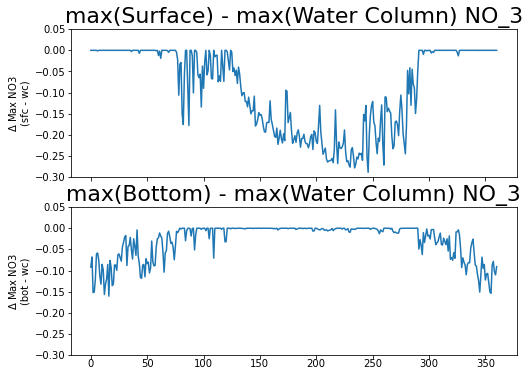

In [20]:
fig, axs = plt.subplots(2,1, figsize = (8,6))
axs[0].plot(np.asarray(sfc['max'])-np.asarray(wc['max']))
axs[1].plot(np.asarray(bot['max'])-np.asarray(wc['max']))

axs[0].set_title('max(Surface) - max(Water Column) NO_3',fontsize=22)
axs[1].set_title('max(Bottom) - max(Water Column) NO_3',fontsize=22)

axs[0].set_ylabel('$\Delta$ Max NO3 \n(sfc - wc)')
axs[1].set_ylabel('$\Delta$ Max NO3 \n(bot - wc)')
axs[0].set_xticklabels('')
for ii in range(0,2):
    axs[ii].set_ylim(-.3,0.05)
    
plt.savefig(pathlib.Path(ssm['paths']['graphics'])/'AnoxDaysDiff'/'BHAMbay_NO3_MaxDifference_TS.png',
            bbox_inches='tight',format='png')

## Difference between surface/bottom mean and water column mean

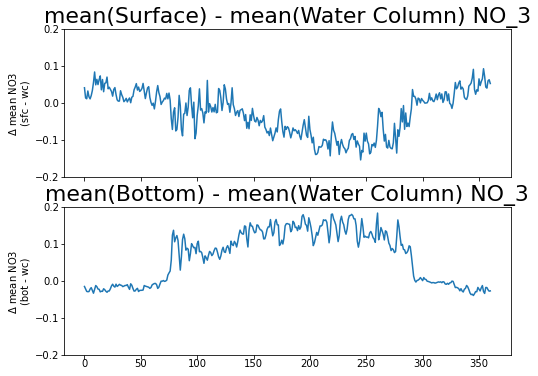

In [21]:
stat_type='mean'
fig, axs = plt.subplots(2,1, figsize = (8,6))
axs[0].plot(np.asarray(sfc[stat_type])-np.asarray(wc[stat_type]))
axs[1].plot(np.asarray(bot[stat_type])-np.asarray(wc[stat_type]))

axs[0].set_title(f'{stat_type}(Surface) - {stat_type}(Water Column) NO_3',fontsize=22)
axs[1].set_title(f'{stat_type}(Bottom) - {stat_type}(Water Column) NO_3',fontsize=22)

axs[0].set_ylabel(f'$\Delta$ {stat_type} NO3 \n(sfc - wc)')
axs[1].set_ylabel(f'$\Delta$ {stat_type} NO3 \n(bot - wc)')
axs[0].set_xticklabels('')
for ii in range(0,2):
    axs[ii].set_ylim(-.2,0.2)

In [22]:
no3_2d = ds['NO3'][:,:,node_id-1]
no3_2d.shape

(8784, 10)

In [23]:
doxg_2d = ds['DOXG'][:,:,node_id-1]
doxg_2d.shape

(8784, 10)

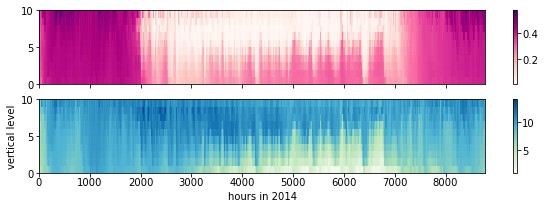

In [25]:
fig, axs = plt.subplots(2,1, figsize = (10,3))
no3mesh=axs[0].pcolormesh(np.flip(no3_2d.transpose(),axis=0),cmap='RdPu')
doxgmesh=axs[1].pcolormesh(np.flip(doxg_2d.transpose(),axis=0),cmap='GnBu')
axs[0].set_xticklabels('')
cb0=fig.colorbar(no3mesh, ax=axs[0])
cb1=fig.colorbar(doxgmesh, ax=axs[1])
axs[1].set_xlabel('hours in 2014')
axs[1].set_ylabel('vertical level')
plt.savefig(pathlib.Path(ssm['paths']['graphics'])/'Hourly_NO3_DOXG.png',
                bbox_inches='tight',format='png')

In [ ]:
no3_2d_t=no3_2d.transpose()
no3_sfc=no3_2d[:,0]
no3_bot=no3_2d[:,9]

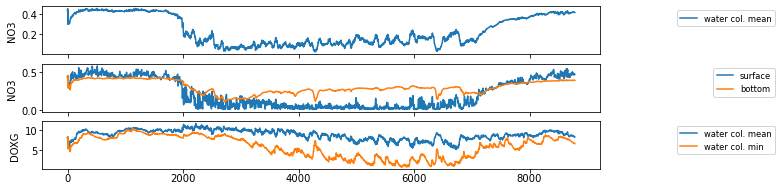

In [30]:
fig, axs = plt.subplots(3,1, figsize = (10,3))
# water column no3
axs[0].plot(np.mean(no3_2d_t,axis=0),label='water col. mean')
axs[1].plot(no3_sfc,label='surface')
axs[1].plot(no3_bot,label='bottom')
axs[2].plot(np.mean(doxg_2d.transpose(),axis=0),label='water col. mean')
axs[2].plot(np.min(doxg_2d.transpose(),axis=0),label='water col. min')
for ii in [0,1]:
    axs[ii].set_xticklabels('')
for ii in [0,1,2]:
    leg=axs[ii].legend(
        bbox_to_anchor=(1.32,1),
        loc='upper right'
    )
axs[0].set_ylabel('NO3')
axs[1].set_ylabel('NO3')
axs[2].set_ylabel('DOXG')
plt.savefig(pathlib.Path(ssm['paths']['graphics'])/'TS_NO3_DOXG.png',
                bbox_inches='tight',format='png')

In [28]:
no3_2d.shape

(8784, 10)